# Evaluation: deep learning for analysing immune cell interactions

## Colab file setup
don't run this if on local

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/l4_project')
sys.path.append('/content/gdrive/My Drive/l4_project/src')

In [0]:
%cd /content/gdrive/My Drive/l4_project/src

In [0]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


## Imports

In [1]:
import numpy as np
import tensorflow.keras
from tensorflow.keras.models import load_model

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# (hopefully) disable tensorflow 2.0 warnings
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

# disable annoying UMAP numba warnings (bad for readability)
import warnings
warnings.filterwarnings('ignore')

In [3]:
from models import make_autoencoder, make_regression, train
from models import evaluate_regression, evaluate_autoencoder
from clustering import run_both, umap_fn

from evaluation_helpers import plot_clusters, show_image
from dataset_helpers import get_label, combine_images, efficient_shuffle, remove_faulty

# WARNING: evaluation_path, repo_path will have to be changed if running on your own machine
from config import RS, evaluation_path, repo_path

## Evaluation parameters
Change this for all the different datasets to evaluate.

In [4]:
mask = False # use True if background-correcting the images 
data_file = repo_path + "data/sample_data/processed/sample_images.npz"
metrics_file = repo_path + "data/sample_data/processed/sample_overlaps.npz"
if mask:
    weights = [repo_path + "data/weights/decoder_masked.h5",
            repo_path + "data/weights/encoder_masked.h5",
            repo_path + "data/weights/regression_masked.h5"]
else:
    weights = [repo_path + "data/weights/decoder.h5",
            repo_path + "data/weights/encoder.h5",
            repo_path + "data/weights/regression.h5"]
# weights = None to train a new model
tag = "sample" 

## Load and pre-process data

In [5]:
# get images
print("{} is being loaded".format(data_file))
data = np.load(data_file)
x = data['x']
filenames = data['y']

/Users/Leonore/Documents/Workspace/l4proj/data/sample_data/processed/sample_images.npz is being loaded


In [6]:
# preprocess
print("Combining images.")
x_combined, y_combined = combine_images(x, filenames, mask=mask)
x = None # save memory

Combining images.
Images preprocessed. Size of dataset: 1800


In [7]:
print("Overlap metrics are being loaded from {}".format(metrics_file))
metrics = np.load(metrics_file)
y_overlaps = metrics['overlaps']*100

Overlap metrics are being loaded from /Users/Leonore/Documents/Workspace/l4proj/data/sample_data/processed/sample_overlaps.npz


In [8]:
y_no_faulty = remove_faulty(filenames) # remove faulty labels for regression evaluation

efficient_shuffle(x_combined, y_combined, y_overlaps, y_no_faulty, random_state=RS)

assert len(x_combined) == len(y_combined) == len(y_overlaps) == len(y_no_faulty)

Faulty labels removed. Size of labels: 1800


## Build the autoencoder and regression models
Either from weights or training.

In [9]:
if weights:
    print("Decoder file is {}".format(weights[0]))
    decoder = load_model(weights[0])
    print("Encoder file is {}".format(weights[1]))
    encoder = load_model(weights[1], compile=False)
    print("Regression file is {}".format(weights[2]))
    regression = load_model(weights[2])
else:
    x_train, x_test, y_train, y_test = x_combined[:-1000], x_combined[-1000:], y_combined[:-1000], y_combined[-1000:]

    # not recommended on local - could take hours and strain memory
    print("Training autoencoder... be aware this might take a long time")
    decoder, encoder = make_autoencoder()
    train(decoder, x_train, x_train, tag=tag)

    print("Training regression model... be aware this might take a long time")
    regression = make_regression(encoder)
    train(regression, x_train, y_train, tag=tag)

    decoder.save('decoder_{}.h5'.format(tag))
    encoder.save('encoder_{}.h5'.format(tag))
    regression.save('regression_{}.h5'.format(tag))

Decoder file is /Users/Leonore/Documents/Workspace/l4proj/data/weights/decoder.h5
Encoder file is /Users/Leonore/Documents/Workspace/l4proj/data/weights/encoder.h5
Regression file is /Users/Leonore/Documents/Workspace/l4proj/data/weights/regression.h5


## Evaluate

### Evaluate autoencoder:

1800/1800 [==============================] - 119s 66ms/sample - loss: 0.0257
Loss: 0.025711172363824315


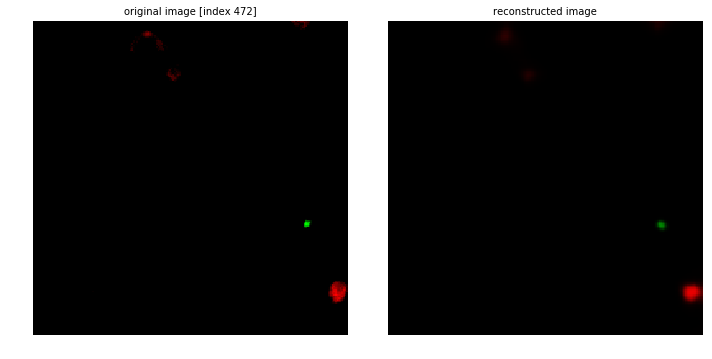

In [10]:
evaluate_autoencoder(decoder, x_combined, tag=tag)

In [10]:
# run clustering
encoded_imgs = encoder.predict(x_combined)

In [11]:
x_umap = umap_fn(encoded_imgs, random_state=RS, n_neighbors=30, min_dist=0.8)

UMAP dimensionality reduction started at 18:46:02
UMAP took 0:00:10.442277 to finish


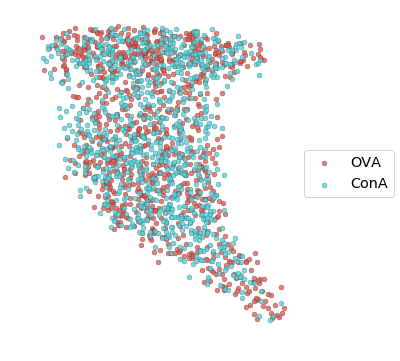

In [12]:
plot_clusters(x_umap, y_combined, labels=["OVA", "ConA"], tag=tag+'_umap')

In [13]:
def plot_clusters_with_size(X, y, s, labels=["Unstimulated", "OVA", "ConA"], tag=None):
    targets = np.unique(y)
    shades = np.array(sns.color_palette("hls", len(labels)))

    y = np.array(y)

    fig = plt.figure(figsize=(6,6))
    ax = plt.subplot()

    for target, color, label in zip(targets, shades, labels):
        sc = plt.scatter(X[y==target, 0], X[y==target, 1], c=[color], s=(s[y==target]+1)*10, label=label, edgecolor="k", lw=0.2, alpha=0.75)

    plt.legend(loc='lower right', fontsize='x-large')
    ax.axis('off')
    ax.grid(False)
    plt.tight_layout()

    if tag:
        plt.savefig(evaluation_path + "clustering/" + tag + ".png", dpi=300)

    plt.show()

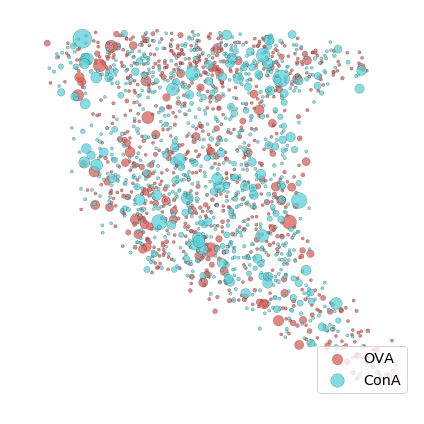

In [14]:
plot_clusters_with_size(x_umap, y_combined, y_overlaps, labels=["OVA", "ConA"], tag=tag+'_umap_size')

### Evaluate regression:

In [10]:
# run regression
print("Running regression using encoder model...")

y_pred = regression.predict(x_combined)

Running regression using encoder model...


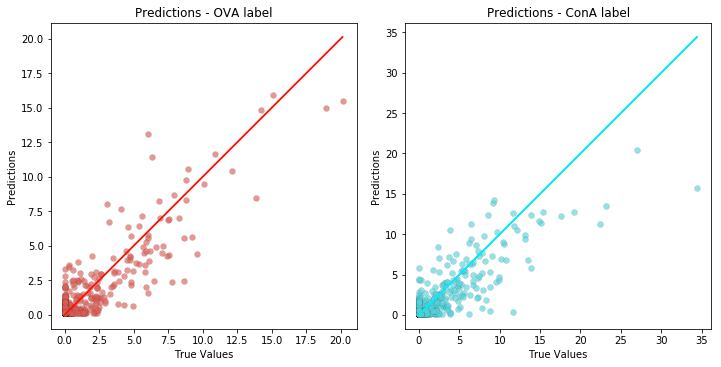

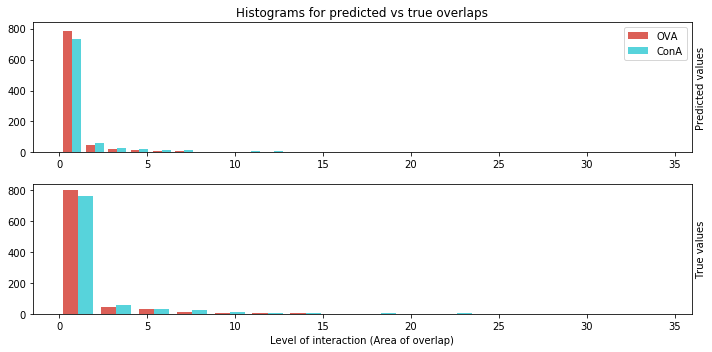

MSE score: 1.743 -- this is the average square difference between true and predicted
RMSE score: 1.320 -- difference between T and P in DV unit
SD of predictions: 2.112

Scores for OVA
RMSE score: 0.953
SD: 1.837

Scores for ConA
RMSE score: 1.606
SD: 2.346



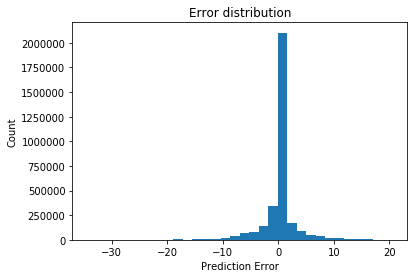

In [11]:
evaluate_regression(y_overlaps, y_pred, y_no_faulty, labels=["OVA", "ConA"], tag=tag)